In [64]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
conn = sqlite3.connect("speed_cam.db")

query = "SELECT idx,log_timestamp,ave_speed,direction from speed"
df = pd.read_sql_query(query, conn)
conn.close()

In [66]:
# Normalize datetime to the hour
df['log_timestamp'] = pd.to_datetime(df['log_timestamp'], format="\"%Y-%m-%d %H:%M:%S\"")
df['hour'] = df['log_timestamp'].dt.hour
df['day_of_week'] = df['log_timestamp'].dt.strftime('%A')

# Remove timestamps before experiment start (Sat Nov 4)
filter_timestamp = pd.to_datetime('2023-11-04 00:00:00')
df = df[df['log_timestamp'] >= filter_timestamp]

print(df['log_timestamp'].min(), df['log_timestamp'].max())
print(df['log_timestamp'].max() - df['log_timestamp'].min())

# It's been observed anything under 15km/h is people slowing down to park, delivery trucks curbside, and similar.
# This data is also not pertinent to the experiment, so we can remove it.
original = df.shape[0]
df = df[df['ave_speed'] >= 15]
removed = original - df.shape[0]
print(f"Records removed: {removed}")
df

2023-11-04 00:32:33 2023-11-10 20:59:58
6 days 20:27:25
Records removed: 291


,idx,log_timestamp,ave_speed,direction,hour,day_of_week
1532,20231104-0032333,2023-11-04 00:32:33,33.16,R2L,0,Saturday
1533,20231104-0032359,2023-11-04 00:32:35,34.43,R2L,0,Saturday
1534,20231104-0038020,2023-11-04 00:38:02,44.26,R2L,0,Saturday
1535,20231104-0102120,2023-11-04 01:02:12,28.27,R2L,1,Saturday
1536,20231104-0106199,2023-11-04 01:06:19,33.77,L2R,1,Saturday
...,...,...,...,...,...,...
6488,20231110-2052138,2023-11-10 20:52:13,34.83,R2L,20,Friday
6489,20231110-2053039,2023-11-10 20:53:03,37.00,R2L,20,Friday
6490,20231110-2054521,2023-11-10 20:54:52,35.05,L2R,20,Friday
6491,20231110-2055283,2023-11-10 20:55:28,27.47,L2R,20,Friday


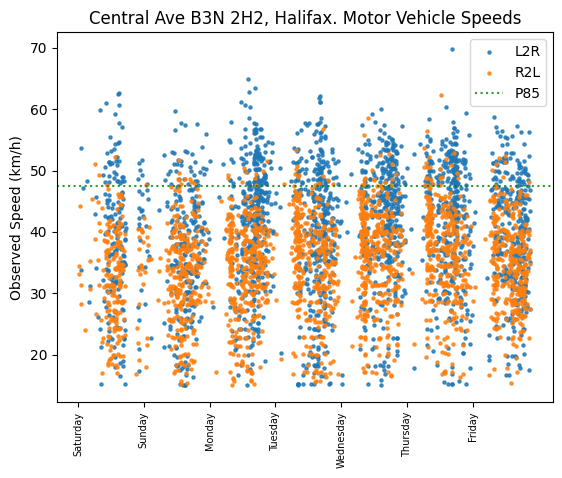

In [67]:
unique_days = df['log_timestamp'].dt.date.unique()

groups = df.groupby('direction')
for direction, group in groups:
    plt.scatter(group['log_timestamp'], group['ave_speed'], label=direction, alpha=0.8, s=5)

plt.ylabel('Observed Speed (km/h)')
plt.xticks(unique_days, [day.strftime('%A') for day in unique_days], size=7, rotation=90)

# Draw the 85th line
p85 = df['ave_speed'].quantile(0.85)
plt.axhline(y=p85, color='green', linestyle=':', alpha=0.8, label='P85')

plt.legend()
plt.title("Central Ave B3N 2H2, Halifax. Motor Vehicle Speeds")
plt.show()

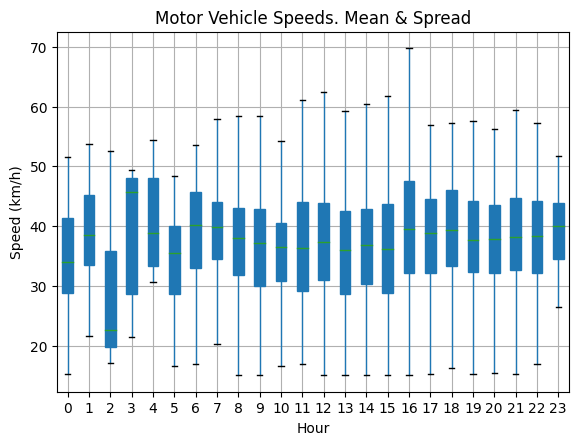

In [68]:
# Box Plot
boxplot = df.boxplot(column='ave_speed', by='hour', patch_artist=True, showfliers=False)
plt.title('Motor Vehicle Speeds. Mean & Spread')
plt.suptitle('')
plt.ylabel('Speed (km/h)')
plt.xlabel('Hour')
plt.show()

In [69]:
# Finally, some numbers!
p85 = df['ave_speed'].quantile(0.85)
print(f"Overall 85th percentile of (15% of vehicles travelling faster than): {p85}")
for direction, group in df.groupby('direction'):
  p85 = group['ave_speed'].quantile(0.85)
  print(f"85th percentile of {direction} is: {p85}")
median = df['ave_speed'].median()
print(f"Median is: {median}")
mean = df['ave_speed'].mean()
print(f"Mean is: {mean}")
print(f"Total observed within date range (after filtering): {len(df)}")

Overall 85th percentile of (15% of vehicles travelling faster than): 47.5465
85th percentile of L2R is: 50.603
85th percentile of R2L is: 42.5865
Median is: 37.84
Mean is: 37.4810642398287
Total observed within date range (after filtering): 4670


In [70]:
df.to_csv("speed_results.csv", index=False)